In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cats-dogs/val.csv
/kaggle/input/cats-dogs/train.csv
/kaggle/input/cats-dogs/val/classname.txt
/kaggle/input/cats-dogs/val/dog/havanese_144_jpg.rf.d3e2e8cb9a7801e61894e372c4f1e1bb.jpg
/kaggle/input/cats-dogs/val/dog/american_pit_bull_terrier_135_jpg.rf.f23ba7a8a1017fc71e62dcdeb3af9fa9.jpg
/kaggle/input/cats-dogs/val/dog/great_pyrenees_190_jpg.rf.ebd07e7aae6a416425fa1f3c89872b61.jpg
/kaggle/input/cats-dogs/val/dog/great_pyrenees_144_jpg.rf.d416d150a51cd8c6ae1489957c49e01b.jpg
/kaggle/input/cats-dogs/val/dog/chihuahua_17_jpg.rf.d97aa2c7e61de5128686d82b87c95215.jpg
/kaggle/input/cats-dogs/val/dog/english_cocker_spaniel_17_jpg.rf.f22312874dde3803847df16bcfe12f83.jpg
/kaggle/input/cats-dogs/val/dog/american_bulldog_148_jpg.rf.f0a7b86489589aa05534a6f8cb0fe70a.jpg
/kaggle/input/cats-dogs/val/dog/english_cocker_spaniel_121_jpg.rf.db065f7b515f83644b2fcb7525073d0b.jpg
/kaggle/input/cats-dogs/val/dog/pomeranian_134_jpg.rf.fb1b528eaddde044d1bb964e8c47b36e.jpg
/kaggle/input/cats-dogs/v

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
# Define transformations for training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
])


In [4]:
# Dataset paths
data_dir = "/kaggle/input/cats-dogs"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
class_names = train_dataset.classes

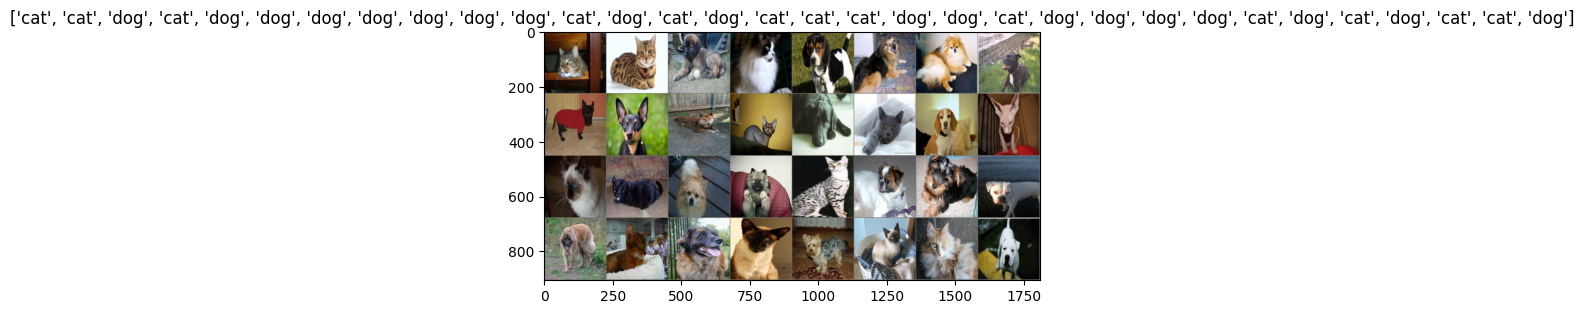

In [5]:
def imshow(inp, title=None):
    """Display image for PyTorch Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes_batch = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes_batch])


In [6]:
device = torch.device("cuda") 
# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# Freeze all layers except the last fully connected
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier fully connected layer for cat vs dog (2 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [8]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs_batch, labels_batch in train_loader:
        inputs_batch = inputs_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs_batch.size(0)
        running_corrects += torch.sum(preds == labels_batch.data)
        total += labels_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


Epoch 1/5 Loss: 0.4998 Acc: 0.7564
Epoch 2/5 Loss: 0.2865 Acc: 0.8800
Epoch 3/5 Loss: 0.1494 Acc: 0.9891
Epoch 4/5 Loss: 0.1090 Acc: 0.9818
Epoch 5/5 Loss: 0.0998 Acc: 0.9818


In [9]:
model.eval()
val_corrects = 0
val_total = 0

with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        _, val_preds = torch.max(val_outputs, 1)
        val_corrects += torch.sum(val_preds == val_labels.data)
        val_total += val_labels.size(0)

val_acc = val_corrects.double() / val_total
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.9857


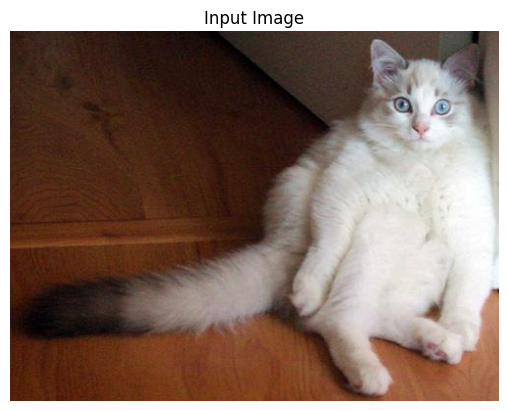

Predicted class: cat


'cat'

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

def predict_image(image_path):
    # Load image
    img = Image.open(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Define the transformations matching training preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

    # Preprocess the image and add batch dimension
    img_t = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(img_t)
        _, pred = torch.max(out, 1)

    predicted_label = class_names[pred.item()]
    print("Predicted class:", predicted_label)
    return predicted_label

# Example usage
image_path = "/kaggle/input/cats-dogs/val/cat/Ragdoll_158_jpg.rf.f9c36ee093139d00405f4f0838dd00d8.jpg"
predict_image(image_path)
